In [1]:
import time
import copy
import warnings
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import mean_absolute_error
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Будем вести логирование.
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO, filename="log.log",filemode="a")

In [4]:
%matplotlib inline

In [5]:
# Функция для отрисовки матрицы корреляции столбцов датафрейма.    
def show_correlogram(df):
    plt.figure(figsize=(12,12), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, center=0, annot=True, cbar=False
    )
    plt.title('Корреляция между признаками', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=12)
    plt.show()
    

# Функция для записи логов.
def make_log(log_type, model, predict_info, target, predict):
    if log_type == "fit_predict":
        logging.info(model + ':\n{}\nShape = {}'.format(predict_info, predict_info.shape))
        
    elif log_type == "predict":
        logging.info('Предсказание для валидации:\n{}\nShape = {}'.format(predict_info, predict_info.shape))
        logging.info('Считаем метрику...')
        logging.info('Метрика MAE: {} \n'.format(mean_absolute_error(target, predict)))
        

# Функция для сохранения файла для сабмита.
def make_submission_file(predict, filename):
    df_sample_submission = copy.deepcopy(df_sample)
    df_sample_submission[TARGET_NAME] = predict.data[:, 0]
    df_sample_submission.to_csv(filename, index=False)
    df_sample_submission.head()

### 3. Моделирование.


#### 3.1 Построение выводов о правильном разбиении для обучения и валидации - train test split

Как мы выяснили в ноутбуке EDA в train.csv содержится 75450 циклов дыхания по 80 наблюдений в каждом. Нужно удалить 73 цикла дыхания с аномально отрицательным таргетом. Останется 75377 циклов дыхания.
Если разделить 75450 в пропорции 80/20 получим 60360 - это 80% и 15090 - это 20%.
Возьмём первые 60360 циклов дыхания в качестве трейна, а оставшиеся 15090 в качестве валидации.
Разделителем будет n = 60360*80

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample = pd.read_csv('sample_submission.csv')

columns = ["id", "breath_id", "R", "C", "time_step", "u_in", "u_out"]

In [7]:
# 60360 + 15090 = 75450

n = 60360*80

train = df_train[df_train.id <= n]
val = df_train[df_train.id > n]

In [8]:
train["breath_id"].value_counts()

1         80
66993     80
66967     80
66969     80
66971     80
          ..
33444     80
33445     80
33448     80
33449     80
100615    80
Name: breath_id, Length: 60360, dtype: int64

In [9]:
val["breath_id"].value_counts()

100616    80
117361    80
117343    80
117344    80
117345    80
          ..
108933    80
108934    80
108935    80
108937    80
125749    80
Name: breath_id, Length: 15090, dtype: int64

Теперь найдём пересечение трейна и валидации. Если они не перескаются (а они не должны пересекаться), то пересечение будет 
пустым датафреймом.

In [10]:
dataframes_intersection = pd.merge(train, val, how='inner', on=['breath_id'])

dataframes_intersection

,id_x,breath_id,R_x,C_x,time_step_x,u_in_x,u_out_x,pressure_x,id_y,R_y,C_y,time_step_y,u_in_y,u_out_y,pressure_y


Да, видим, что пересечение трейна и валидации пустое. Т.е. нет утечки данных. То, что нам и нужно.

### Перед тем, как начнём генерировать новые признаки в порядке эксперимента обучим три варианта lightautoml на исходных данных train.csv без генерации признаков. Для этого разделим трейн на трейновую и валидационную часть. Замерим скор и сравним. Уже после этого сгенерируем 3 вида добавленных признаков и будем учить 3 вида lightautoml на всём train.csv. Проверять будем сделав предикт на test.csv и засабмитив файл. Скриншот с лидерборда по каждому варианту вставлю в ноутбук. Всего будет 3 вида добавленных признаков * на 3 вида lightautoml = 9 вариантов (плюс 2 дополнительных в самом конце ноутбука). 

In [11]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 3600
TARGET_NAME = 'pressure'

# Для воспроизводимости.
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [12]:
task = Task('reg', loss='mae', metric='mae')

In [13]:
roles = {
    'drop': 'id',
    'group': 'breath_id', 
    'target': TARGET_NAME
}

#### Сначала в use_algos используем только linear_l2

In [14]:
%%time

automl_var1 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_var1 = automl_var1.fit_predict(train, roles=roles, verbose=1)

make_log("fit_predict", "automl_var1", oof_pred_var1, None, None)

[09:37:36] Stdout logging level is INFO.
[09:37:36] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[09:37:36] Task: reg

[09:37:36] Start automl preset with listed constraints:
[09:37:36] - time: 3600.00 seconds
[09:37:36] - CPU: 4 cores
[09:37:36] - memory: 16 GB

[09:37:36] Train data shape: (4828800, 8)

[09:37:39] Layer 1 train process start. Time left 3597.38 secs
[09:37:40] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[09:41:40] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.5582612231305304
[09:41:40] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[09:41:40] Time left 3356.26 secs

[09:41:40] Layer 1 training completed.

[09:41:40] Automl preset training completed in 243.75 seconds

[09:41:40] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 

CPU times: total: 15min 58s
Wall time: 4min 3s


In [15]:
%%time

val_pred_var1 = automl_var1.predict(val[columns])

make_log("predict", "automl_var1", val_pred_var1, val[TARGET_NAME].values, val_pred_var1.data[:, 0])

print("Train MAE = ", mean_absolute_error(train[TARGET_NAME].values, oof_pred_var1.data[:, 0]))
print("Val MAE = ", mean_absolute_error(val[TARGET_NAME].values, val_pred_var1.data[:, 0]))

Train MAE =  3.5582612231305304
Val MAE =  3.54795691180654
CPU times: total: 984 ms
Wall time: 398 ms


#### Теперь в use_algos используем только lgb

In [16]:
%%time

automl_var2 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_var2 = automl_var2.fit_predict(train, roles=roles, verbose=1)

make_log("fit_predict", "automl_var2", oof_pred_var2, None, None)

[09:41:42] Stdout logging level is INFO.
[09:41:42] Task: reg

[09:41:42] Start automl preset with listed constraints:
[09:41:42] - time: 3600.00 seconds
[09:41:42] - CPU: 4 cores
[09:41:42] - memory: 16 GB

[09:41:42] Train data shape: (4828800, 8)

[09:41:43] Layer 1 train process start. Time left 3598.24 secs
[09:47:30] Selector_LightGBM fitting and predicting completed
[09:47:30] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[10:16:22] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -1.8999081893413967
[10:16:22] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[10:16:22] Time left 1519.59 secs

[10:16:22] Layer 1 training completed.

[10:16:22] Automl preset training completed in 2080.42 seconds

[10:16:22] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

CPU times: total: 2h 17min 43s
Wall time: 34min 40s


In [17]:
%%time

val_pred_var2 = automl_var2.predict(val[columns])

make_log("predict", "automl_var2", val_pred_var2, val[TARGET_NAME].values, val_pred_var2.data[:, 0])

print("Train MAE = ", mean_absolute_error(train[TARGET_NAME].values, oof_pred_var2.data[:, 0]))
print("Val MAE = ", mean_absolute_error(val[TARGET_NAME].values, val_pred_var2.data[:, 0]))

Train MAE =  1.8999081893413967
Val MAE =  1.900659646725017
CPU times: total: 18min 29s
Wall time: 4min 39s


#### И наконец в use_algos используем linear_l2 и lgb

In [14]:
%%time

automl_var3 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_var3 = automl_var3.fit_predict(train, roles=roles, verbose=1)

make_log("fit_predict", "automl_var3", oof_pred_var3, None, None)

[13:10:14] Stdout logging level is INFO.
[13:10:14] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[13:10:14] Task: reg

[13:10:14] Start automl preset with listed constraints:
[13:10:14] - time: 3600.00 seconds
[13:10:14] - CPU: 4 cores
[13:10:14] - memory: 16 GB

[13:10:14] Train data shape: (4828800, 8)

[13:10:17] Layer 1 train process start. Time left 3597.27 secs
[13:10:17] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[13:14:30] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.5581052396857955
[13:14:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[13:14:30] Time left 3343.45 secs

[13:18:41] Selector_LightGBM fitting and predicting completed
[13:18:41] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[13:39:30] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.8999081893413967
[13:39:30] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[13:39:30] Time left 1844.26 secs

[13:39:30] Layer

In [15]:
%%time

val_pred_var3 = automl_var3.predict(val[columns])

make_log("predict", "automl_var3", val_pred_var3, val[TARGET_NAME].values, val_pred_var3.data[:, 0])

print("Train MAE = ", mean_absolute_error(train[TARGET_NAME].values, oof_pred_var3.data[:, 0]))
print("Val MAE = ", mean_absolute_error(val[TARGET_NAME].values, val_pred_var3.data[:, 0]))

Train MAE =  1.8999081893413967
Val MAE =  1.900659646725017
CPU times: total: 13min 32s
Wall time: 3min 24s


Видим, что во втором и третьем случае получился одинаковый результат. 

#### 3.2 LightAutoML baseline

#### Создадим 3 функции для генерации признаков.

In [16]:
# Функция добавляет лаги с шагом 1, 2 и -1, -2 к признаку u_in. 
def generate_features_v1(df, mode):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data = data.fillna(0)
    
    if mode == "train":
        data_pressure_subzero = data[data['pressure'] < 0]
        pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
        data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]

    return data


# Функция добавляет кумулятивную сумму, первое/последнее значение, минимум/максимум, медиану признака u_in. 
def generate_features_v2(df, mode):
    data = copy.deepcopy(df)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    data = data.fillna(0)
    
    if mode == "train":
        data_pressure_subzero = data[data['pressure'] < 0]
        pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
        data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]

    return data


# Функция объединяет добавление признаков из первых двух версий функции.
def generate_features_v3(df, mode):
    data = copy.deepcopy(df)
    data['u_in_lag_1'] = data.groupby('breath_id')['u_in'].shift(1)
    data['u_in_lag_2'] = data.groupby('breath_id')['u_in'].shift(2)
    data['u_in_lag_-1'] = data.groupby('breath_id')['u_in'].shift(-1)
    data['u_in_lag_-2'] = data.groupby('breath_id')['u_in'].shift(-2)
    data['u_in_cumsum'] = data['u_in'].groupby(data['breath_id']).cumsum()
    data['u_in_first'] = data.groupby('breath_id')['u_in'].transform('first')
    data['u_in_last'] = data.groupby('breath_id')['u_in'].transform('last')
    data['u_in_min'] = data.groupby('breath_id')['u_in'].transform('min')
    data['u_in_max'] = data.groupby('breath_id')['u_in'].transform('max')
    data['u_in_median'] = data.groupby('breath_id')['u_in'].transform('median')
    data = data.fillna(0)
    
    if mode == "train":
        data_pressure_subzero = data[data['pressure'] < 0]
        pressure_subzero_id = list(set(data_pressure_subzero.breath_id.values))
        data = data[data['breath_id'].apply(lambda x: x not in pressure_subzero_id)]

    return data

In [17]:
# Сгенерируем 3 трейновых датасета тремя разными функциями.
df_train_v1 = generate_features_v1(df_train, "train")
df_train_v2 = generate_features_v2(df_train, "train")
df_train_v3 = generate_features_v3(df_train, "train")

In [18]:
df_train_v1

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822
2,3,1,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850
3,4,1,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866
4,5,1,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486
...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,1.420711,1.353205,1.488497,1.558978
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,1.489714,1.420711,1.558978,1.272663
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,1.488497,1.489714,1.272663,1.482739
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,1.558978,1.488497,1.482739,0.000000


In [19]:
df_train_v1.isnull().sum()

id             0
breath_id      0
R              0
C              0
time_step      0
u_in           0
u_out          0
pressure       0
u_in_lag_1     0
u_in_lag_2     0
u_in_lag_-1    0
u_in_lag_-2    0
dtype: int64

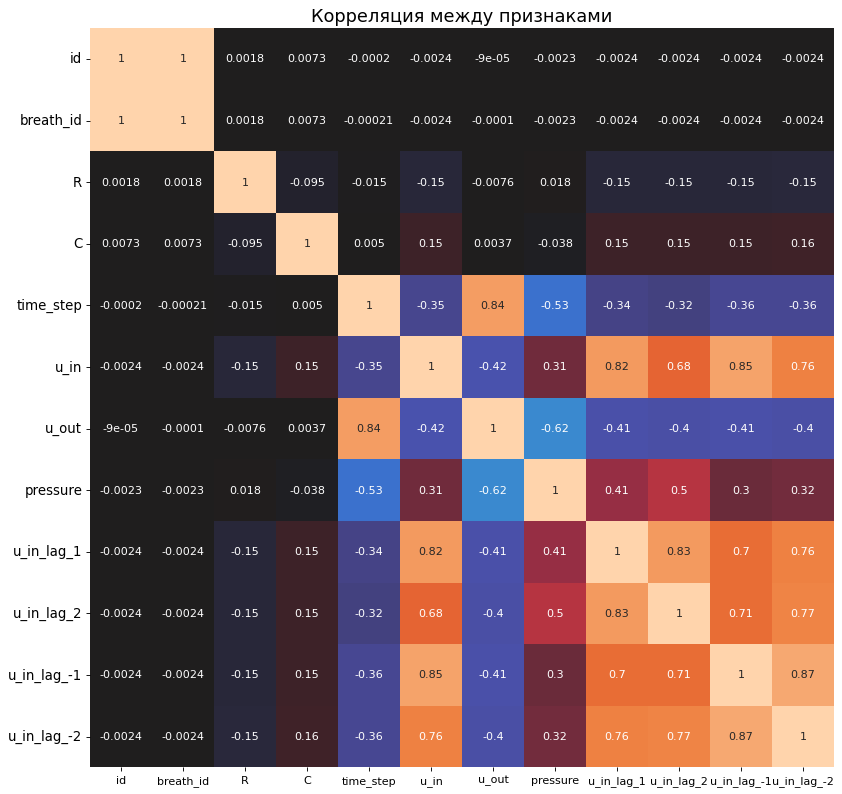

In [20]:
show_correlogram(df_train_v1)

In [21]:
df_train_v2

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,2,1,20,50,0.033652,18.383041,0,5.907794,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,3,1,20,50,0.067514,22.509278,0,7.876254,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,4,1,20,50,0.101542,22.808822,0,11.742872,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,5,1,20,50,0.135756,25.355850,0,12.234987,89.140326,0.083334,4.987079,0.0,28.313036,4.922568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,387.109297,6.030572,1.482739,0.0,25.504196,1.694180
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,388.597794,6.030572,1.482739,0.0,25.504196,1.694180
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,390.156772,6.030572,1.482739,0.0,25.504196,1.694180
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,391.429435,6.030572,1.482739,0.0,25.504196,1.694180


In [22]:
df_train_v2.isnull().sum()

id             0
breath_id      0
R              0
C              0
time_step      0
u_in           0
u_out          0
pressure       0
u_in_cumsum    0
u_in_first     0
u_in_last      0
u_in_min       0
u_in_max       0
u_in_median    0
dtype: int64

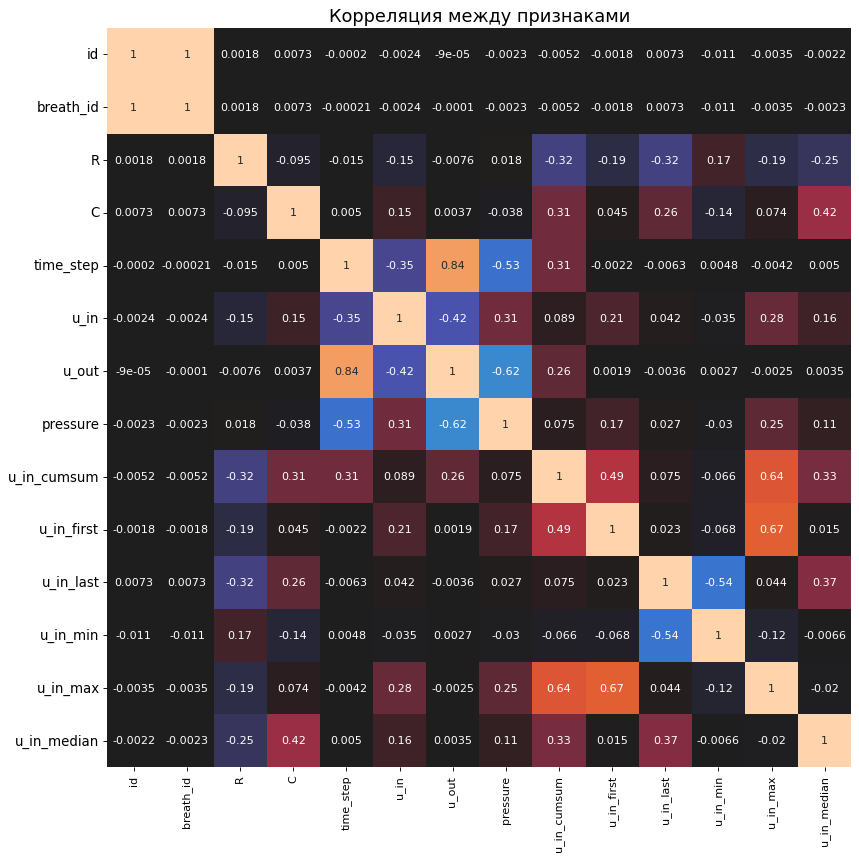

In [23]:
show_correlogram(df_train_v2)

In [24]:
df_train_v3

,id,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_lag_1,u_in_lag_2,u_in_lag_-1,u_in_lag_-2,u_in_cumsum,u_in_first,u_in_last,u_in_min,u_in_max,u_in_median
0,1,1,20,50,0.000000,0.083334,0,5.837492,0.000000,0.000000,18.383041,22.509278,0.083334,0.083334,4.987079,0.0,28.313036,4.922568
1,2,1,20,50,0.033652,18.383041,0,5.907794,0.083334,0.000000,22.509278,22.808822,18.466375,0.083334,4.987079,0.0,28.313036,4.922568
2,3,1,20,50,0.067514,22.509278,0,7.876254,18.383041,0.083334,22.808822,25.355850,40.975653,0.083334,4.987079,0.0,28.313036,4.922568
3,4,1,20,50,0.101542,22.808822,0,11.742872,22.509278,18.383041,25.355850,27.259866,63.784476,0.083334,4.987079,0.0,28.313036,4.922568
4,5,1,20,50,0.135756,25.355850,0,12.234987,22.808822,22.509278,27.259866,27.127486,89.140326,0.083334,4.987079,0.0,28.313036,4.922568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032,1.420711,1.353205,1.488497,1.558978,387.109297,6.030572,1.482739,0.0,25.504196,1.694180
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032,1.489714,1.420711,1.558978,1.272663,388.597794,6.030572,1.482739,0.0,25.504196,1.694180
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729,1.488497,1.489714,1.272663,1.482739,390.156772,6.030572,1.482739,0.0,25.504196,1.694180
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938,1.558978,1.488497,1.482739,0.000000,391.429435,6.030572,1.482739,0.0,25.504196,1.694180


In [25]:
df_train_v3.isnull().sum()

id             0
breath_id      0
R              0
C              0
time_step      0
u_in           0
u_out          0
pressure       0
u_in_lag_1     0
u_in_lag_2     0
u_in_lag_-1    0
u_in_lag_-2    0
u_in_cumsum    0
u_in_first     0
u_in_last      0
u_in_min       0
u_in_max       0
u_in_median    0
dtype: int64

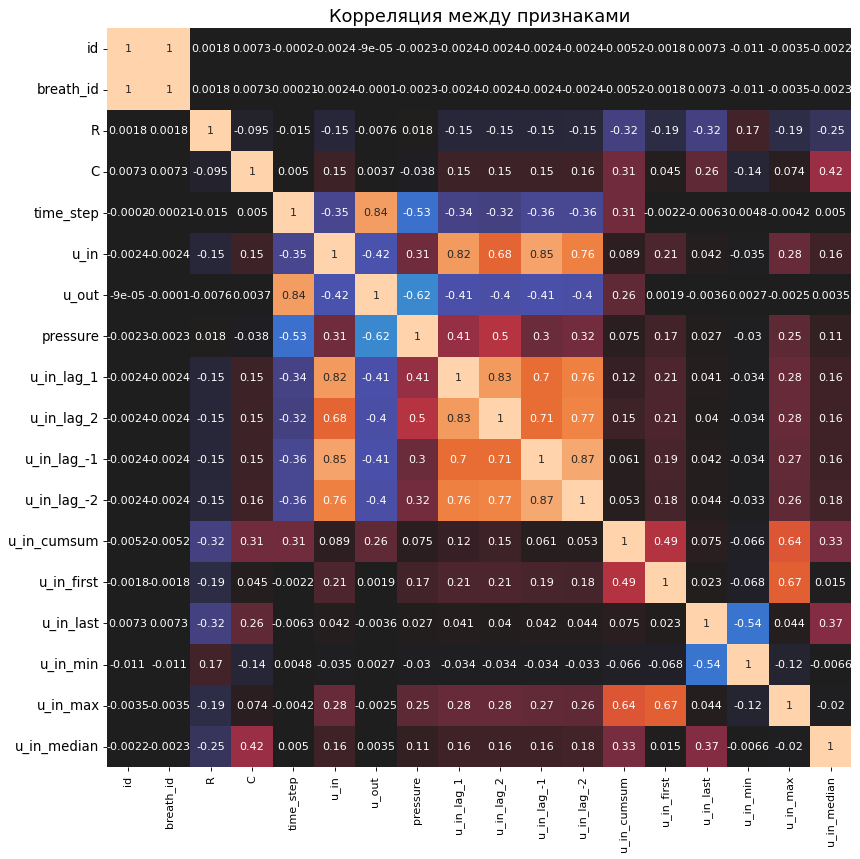

In [26]:
show_correlogram(df_train_v3)

In [27]:
# Сгенерируем новые признаки тремя подходами для тестового множества.
df_test_f1 = generate_features_v1(df_test, "test")
df_test_f2 = generate_features_v2(df_test, "test")
df_test_f3 = generate_features_v3(df_test, "test")

### Теперь посмотрим на 9 вариантов (3 варианта lightautoml на 3-х вариантах добавленных признаков). Будем учить на всем трейне, потом делать предикт на test.csv, делать сабмит и смотреть результат.

In [28]:
task = Task('reg', loss='mae', metric='mae')

#### Третий вариант генерации признаков с автомл, где в use_algos только linear_l2.

In [33]:
%%time

automl_f3_a1 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f3_a1 = automl_f3_a1.fit_predict(df_train_v3, roles=roles, verbose=1)

make_log("fit_predict", "automl_f3_a1", oof_pred_f3_a1, None, None)

[10:59:35] Stdout logging level is INFO.
[10:59:35] Task: reg

[10:59:35] Start automl preset with listed constraints:
[10:59:35] - time: 3600.00 seconds
[10:59:35] - CPU: 4 cores
[10:59:35] - memory: 16 GB

[10:59:35] Train data shape: (6030160, 18)

[10:59:55] Layer 1 train process start. Time left 3579.41 secs
[11:00:00] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:11:39] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.1289602510854344
[11:11:39] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:11:40] Time left 2875.22 secs

[11:11:40] Layer 1 training completed.

[11:11:40] Automl preset training completed in 724.81 seconds

[11:11:40] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 

CPU times: total: 46min 15s
Wall time: 12min 4s


In [34]:
%%time

test_pred_f3_a1 = automl_f3_a1.predict(df_test_f3)

make_submission_file(test_pred_f3_a1, 'submission_f3_a1.csv')

CPU times: total: 10 s
Wall time: 9.01 s


Посмотрим какой скор MAE будет после сабмита.

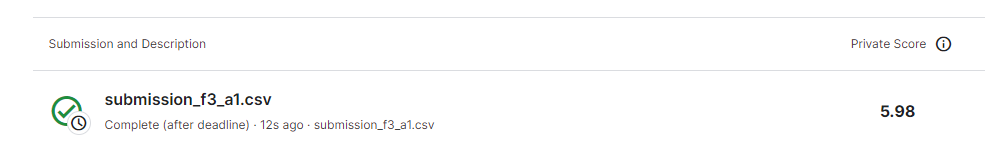

#### Третий вариант генерации признаков с автомл, где в use_algos только lgb.

In [35]:
%%time

automl_f3_a2 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f3_a2 = automl_f3_a2.fit_predict(df_train_v3, roles=roles, verbose=1)

make_log("fit_predict", "automl_f3_a2", oof_pred_f3_a2, None, None)

[11:11:49] Stdout logging level is INFO.
[11:11:49] Task: reg

[11:11:49] Start automl preset with listed constraints:
[11:11:49] - time: 3600.00 seconds
[11:11:49] - CPU: 4 cores
[11:11:49] - memory: 16 GB

[11:11:49] Train data shape: (6030160, 18)

[11:12:08] Layer 1 train process start. Time left 3580.56 secs
[11:20:08] Selector_LightGBM fitting and predicting completed
[11:20:09] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[11:44:04] Time limit exceeded after calculating fold 2

[11:44:04] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.4256934355669552
[11:44:04] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[11:44:04] Time left 1664.67 secs

[11:44:04] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[11:44:04] Layer 1 training completed.

[11:44:04] Automl preset training completed in 1935.36 seconds

[11:44:04] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_

In [36]:
%%time

test_pred_f3_a2 = automl_f3_a2.predict(df_test_f3)

make_submission_file(test_pred_f3_a2, 'submission_f3_a2.csv')

CPU times: total: 28min 56s
Wall time: 7min 20s


Посмотрим какой скор MAE будет после сабмита.

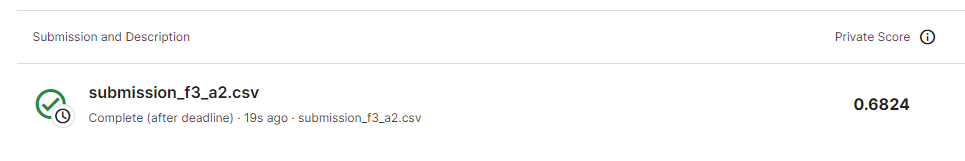

#### Третий вариант генерации признаков с автомл, где в use_algos linear_l2 и lgb.

In [37]:
%%time

automl_f3_a3 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f3_a3 = automl_f3_a3.fit_predict(df_train_v3, roles=roles, verbose=1)

make_log("fit_predict", "automl_f3_a3", oof_pred_f3_a3, None, None)

[11:51:25] Stdout logging level is INFO.
[11:51:25] Task: reg

[11:51:25] Start automl preset with listed constraints:
[11:51:25] - time: 3600.00 seconds
[11:51:25] - CPU: 4 cores
[11:51:25] - memory: 16 GB

[11:51:25] Train data shape: (6030160, 18)

[11:51:30] Layer 1 train process start. Time left 3594.40 secs
[11:51:35] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:02:57] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.128958359776417
[12:02:57] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:02:57] Time left 2908.19 secs

[12:10:54] Selector_LightGBM fitting and predicting completed
[12:10:55] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[12:34:54] Time limit exceeded after calculating fold 2

[12:34:54] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.4256934355900277
[12:34:54] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[12:34:54] Time left 990.46 secs

[12:34:54] Time limit exceeded in one of the tasks. AutoML will blend 

In [38]:
%%time

test_pred_f3_a3 = automl_f3_a3.predict(df_test_f3)

make_submission_file(test_pred_f3_a3, 'submission_f3_a3.csv')

CPU times: total: 28min 46s
Wall time: 7min 19s


Посмотрим какой скор MAE будет после сабмита.

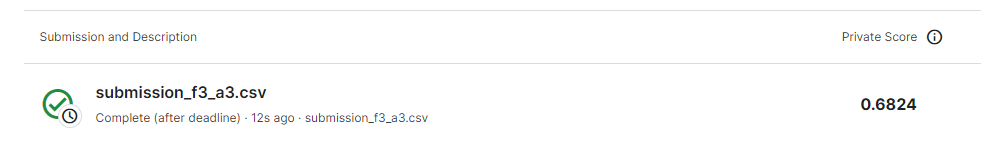

#### Второй вариант генерации признаков с автомл, где в use_algos только linear_l2.

In [39]:
%%time

automl_f2_a1 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f2_a1 = automl_f2_a1.fit_predict(df_train_v2, roles=roles, verbose=1)

make_log("fit_predict", "automl_f2_a1", oof_pred_f2_a1, None, None)

[12:42:18] Stdout logging level is INFO.
[12:42:18] Task: reg

[12:42:18] Start automl preset with listed constraints:
[12:42:18] - time: 3600.00 seconds
[12:42:18] - CPU: 4 cores
[12:42:18] - memory: 16 GB

[12:42:18] Train data shape: (6030160, 14)

[12:42:23] Layer 1 train process start. Time left 3594.81 secs
[12:42:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:47:28] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.444942055496596
[12:47:28] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[12:47:28] Time left 3289.39 secs

[12:47:28] Layer 1 training completed.

[12:47:28] Automl preset training completed in 310.63 seconds

[12:47:28] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 

CPU times: total: 20min 9s
Wall time: 5min 10s


In [40]:
%%time

test_pred_f2_a1 = automl_f2_a1.predict(df_test_f2)

make_submission_file(test_pred_f2_a1, 'submission_f2_a1.csv')

CPU times: total: 8.25 s
Wall time: 6.5 s


Посмотрим какой скор MAE будет после сабмита.

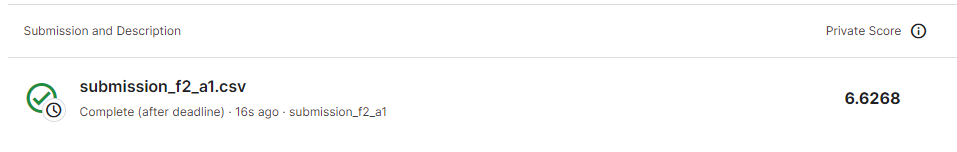

#### Второй вариант генерации признаков с автомл, где в use_algos только lgb.

In [29]:
%%time

automl_f2_a2 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f2_a2 = automl_f2_a2.fit_predict(df_train_v2, roles=roles, verbose=1)

make_log("fit_predict", "automl_f2_a2", oof_pred_f2_a2, None, None)

[13:46:31] Stdout logging level is INFO.
[13:46:31] Task: reg

[13:46:31] Start automl preset with listed constraints:
[13:46:31] - time: 3600.00 seconds
[13:46:31] - CPU: 4 cores
[13:46:31] - memory: 16 GB

[13:46:31] Train data shape: (6030160, 14)

[13:46:37] Layer 1 train process start. Time left 3594.52 secs
[13:52:05] Selector_LightGBM fitting and predicting completed
[13:52:06] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[14:18:53] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.5011708103789123
[14:18:53] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[14:18:53] Time left 1658.50 secs

[14:18:53] Layer 1 training completed.

[14:18:53] Automl preset training completed in 1941.52 seconds

[14:18:53] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

CPU times: total: 2h 8min 40s
Wall time: 32min 21s


In [30]:
%%time

test_pred_f2_a2 = automl_f2_a2.predict(df_test_f2)

make_submission_file(test_pred_f2_a2, 'submission_f2_a2.csv')

CPU times: total: 36min 8s
Wall time: 9min 10s


Посмотрим какой скор MAE будет после сабмита.

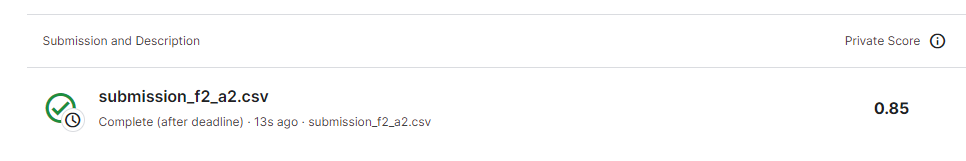

#### Второй вариант генерации признаков с автомл, где в use_algos linear_l2 и lgb.

In [31]:
%%time

automl_f2_a3 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f2_a3 = automl_f2_a3.fit_predict(df_train_v2, roles=roles, verbose=1)

make_log("fit_predict", "automl_f2_a3", oof_pred_f2_a3, None, None)

[14:29:00] Stdout logging level is INFO.
[14:29:00] Task: reg

[14:29:00] Start automl preset with listed constraints:
[14:29:00] - time: 3600.00 seconds
[14:29:00] - CPU: 4 cores
[14:29:00] - memory: 16 GB

[14:29:00] Train data shape: (6030160, 14)

[14:29:04] Layer 1 train process start. Time left 3596.36 secs
[14:29:06] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:33:51] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.444960728485132
[14:33:51] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[14:33:51] Time left 3309.06 secs

[14:39:16] Selector_LightGBM fitting and predicting completed
[14:39:17] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:01:28] Time limit exceeded after calculating fold 3

[15:01:28] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -0.5009022197364058
[15:01:28] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:01:28] Time left 1652.29 secs

[15:01:28] Time limit exceeded in one of the tasks. AutoML will blend

In [32]:
%%time

test_pred_f2_a3 = automl_f2_a3.predict(df_test_f2)

make_submission_file(test_pred_f2_a3, 'submission_f2_a3.csv')

CPU times: total: 28min 47s
Wall time: 7min 17s


Посмотрим какой скор MAE будет после сабмита.

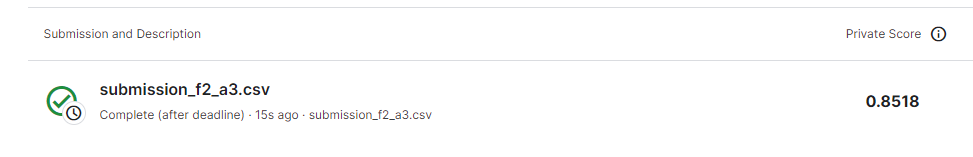

#### Первый вариант генерации признаков с автомл, где в use_algos только linear_l2.

In [33]:
%%time

automl_f1_a1 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f1_a1 = automl_f1_a1.fit_predict(df_train_v1, roles=roles, verbose=1)

make_log("fit_predict", "automl_f1_a1", oof_pred_f1_a1, None, None)

[15:15:25] Stdout logging level is INFO.
[15:15:25] Task: reg

[15:15:25] Start automl preset with listed constraints:
[15:15:25] - time: 3600.00 seconds
[15:15:25] - CPU: 4 cores
[15:15:25] - memory: 16 GB

[15:15:25] Train data shape: (6030160, 12)

[15:15:28] Layer 1 train process start. Time left 3596.41 secs
[15:15:30] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:26:47] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.206876056703038
[15:26:47] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:26:47] Time left 2917.44 secs

[15:26:47] Layer 1 training completed.

[15:26:47] Automl preset training completed in 682.58 seconds

[15:26:47] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2) 

CPU times: total: 45min 6s
Wall time: 11min 22s


In [34]:
%%time

test_pred_f1_a1 = automl_f1_a1.predict(df_test_f1)

make_submission_file(test_pred_f1_a1, 'submission_f1_a1.csv')

CPU times: total: 6.86 s
Wall time: 5.06 s


Посмотрим какой скор MAE будет после сабмита.

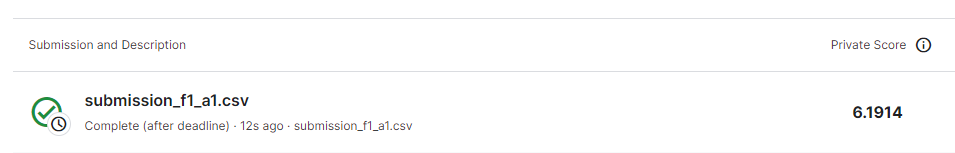

#### Первый вариант генерации признаков с автомл, где в use_algos только lgb.

In [35]:
%%time

automl_f1_a2 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f1_a2 = automl_f1_a2.fit_predict(df_train_v1, roles=roles, verbose=1)

make_log("fit_predict", "automl_f1_a2", oof_pred_f1_a2, None, None)

[15:28:39] Stdout logging level is INFO.
[15:28:39] Task: reg

[15:28:39] Start automl preset with listed constraints:
[15:28:39] - time: 3600.00 seconds
[15:28:39] - CPU: 4 cores
[15:28:39] - memory: 16 GB

[15:28:39] Train data shape: (6030160, 12)

[15:28:42] Layer 1 train process start. Time left 3596.59 secs
[15:34:17] Selector_LightGBM fitting and predicting completed
[15:34:18] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[16:01:51] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -1.1947445393428315
[16:01:51] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[16:01:51] Time left 1608.25 secs

[16:01:51] Layer 1 training completed.

[16:01:51] Automl preset training completed in 1991.77 seconds

[16:01:51] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (5 averaged models Lvl_0_Pipe_0_Mod_0_LightGBM) 

CPU times: total: 2h 12min 6s
Wall time: 33min 11s


In [36]:
%%time

test_pred_f1_a2 = automl_f1_a2.predict(df_test_f1)

make_submission_file(test_pred_f1_a2, 'submission_f1_a2.csv')

CPU times: total: 44min 13s
Wall time: 11min 13s


Посмотрим какой скор MAE будет после сабмита.

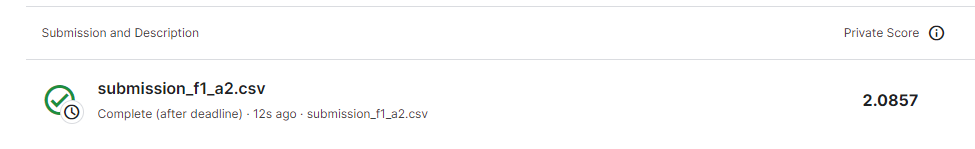

#### Первый вариант генерации признаков с автомл, где в use_algos linear_l2 и lgb.

In [37]:
%%time

automl_f1_a3 = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['linear_l2', 'lgb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f1_a3 = automl_f1_a3.fit_predict(df_train_v1, roles=roles, verbose=1)

make_log("fit_predict", "automl_f1_a3", oof_pred_f1_a3, None, None)

[16:14:50] Stdout logging level is INFO.
[16:14:50] Task: reg

[16:14:50] Start automl preset with listed constraints:
[16:14:50] - time: 3600.00 seconds
[16:14:50] - CPU: 4 cores
[16:14:50] - memory: 16 GB

[16:14:50] Train data shape: (6030160, 12)

[16:14:53] Layer 1 train process start. Time left 3596.42 secs
[16:14:56] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[16:26:12] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -3.2068718649263603
[16:26:12] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[16:26:12] Time left 2918.02 secs

[16:31:35] Selector_LightGBM fitting and predicting completed
[16:31:36] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[16:53:42] Time limit exceeded after calculating fold 3

[16:53:42] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.1956723250952181
[16:53:42] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[16:53:42] Time left 1267.64 secs

[16:53:42] Time limit exceeded in one of the tasks. AutoML will blen

In [38]:
%%time

test_pred_f1_a3 = automl_f1_a3.predict(df_test_f1)

make_submission_file(test_pred_f1_a3, 'submission_f1_a3.csv')

CPU times: total: 35min 46s
Wall time: 9min 3s


Посмотрим какой скор MAE будет после сабмита.

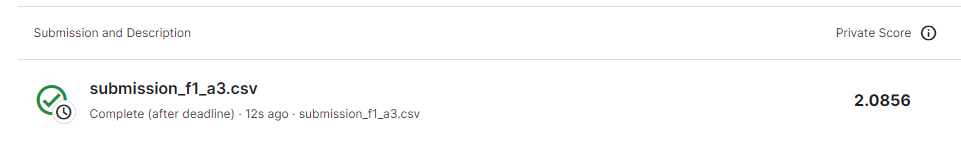

### Из 9 вариантов с разными сгенерированными признаками и разными алгоритмами в автомл лучше всего себя показали варианты f3_a2 и f3_a3. Т.е. с максимальным количеством сгенерированных признаков (функция для генерации №3) и с lgb и linear_l2,lgb в качестве алгоритмов автомл.                                                                                                                                                                                                                                             Лучший результат по метрике MAE получился 0.6824. На лекциях Александр Рыжков говорил, что катбуст бестолковый и очень долго учится и при этом если и превосходит lgb, то на какие-то копейки. Поэтому много от катбуста не жду, но тем не менее попробуем ещё и его. Для генерации признаков теперь будем использовать только функцию №3 (максимальное количество признаков из наших трёх вариантов).

In [39]:
%%time

automl_f3_catboost = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['cb']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f3_catboost = automl_f3_catboost.fit_predict(df_train_v3, roles=roles, verbose=1)

make_log("fit_predict", "automl_f3_catboost", oof_pred_f3_catboost, None, None)

[17:04:23] Stdout logging level is INFO.
[17:04:23] Task: reg

[17:04:23] Start automl preset with listed constraints:
[17:04:23] - time: 3600.00 seconds
[17:04:23] - CPU: 4 cores
[17:04:23] - memory: 16 GB

[17:04:23] Train data shape: (6030160, 18)

[17:04:29] Layer 1 train process start. Time left 3593.80 secs
[17:11:18] Selector_LightGBM fitting and predicting completed
[17:11:19] Start fitting Lvl_0_Pipe_0_Mod_0_CatBoost ...
[17:44:30] Time limit exceeded after calculating fold 2

[17:44:30] Fitting Lvl_0_Pipe_0_Mod_0_CatBoost finished. score = -0.711886116710486
[17:44:30] Lvl_0_Pipe_0_Mod_0_CatBoost fitting and predicting completed
[17:44:30] Time left 1193.23 secs

[17:44:30] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[17:44:30] Layer 1 training completed.

[17:44:30] Automl preset training completed in 2406.80 seconds

[17:44:30] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (3 averaged models Lvl_0_Pipe_0_Mod_0_C

In [40]:
%%time

test_pred_f3_catboost = automl_f3_catboost.predict(df_test_f3)

make_submission_file(test_pred_f3_catboost, 'submission_f3_automl_catboost.csv')

CPU times: total: 19.2 s
Wall time: 8.7 s


Посмотрим какой скор MAE будет после сабмита.

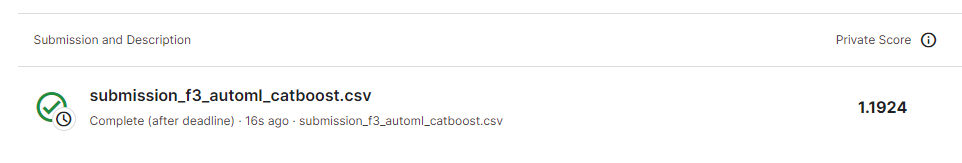

### Видим, что вариант с катбустом не улучшил результаты. Самым лучшим результатом оказался 0.6824. Попробуем ещё применить 2 уровня в автомл. На первом уровне будет lgb, на втором lgb_tuned.

In [41]:
%%time

automl_f3_stack = TabularAutoML(task=task, 
                       timeout=TIMEOUT,
                       cpu_limit=N_THREADS,
                       reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       general_params={'use_algos': [['lgb'], ['lgb_tuned']]},
                       tuning_params={'max_tuning_time': 1800}
                      )

oof_pred_f3_stack = automl_f3_stack.fit_predict(df_train_v3, roles=roles, verbose=1)

make_log("fit_predict", "automl_f3_stack", oof_pred_f3_stack, None, None)

[17:46:08] Stdout logging level is INFO.
[17:46:08] Task: reg

[17:46:08] Start automl preset with listed constraints:
[17:46:08] - time: 3600.00 seconds
[17:46:08] - CPU: 4 cores
[17:46:08] - memory: 16 GB

[17:46:08] Train data shape: (6030160, 18)

[17:46:13] Layer 1 train process start. Time left 3595.01 secs
[17:52:23] Selector_LightGBM fitting and predicting completed
[17:52:23] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[18:04:38] Time limit exceeded after calculating fold 1

[18:04:38] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.4238669918839285
[18:04:38] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[18:04:39] Time left 2489.44 secs

[18:04:39] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[18:04:39] Layer 1 training completed.

[18:04:39] Automl preset training completed in 1110.59 seconds

[18:04:39] Model description:
Final prediction for new objects (level 0) = 
	 1.00000 * (2 averaged models Lvl_0_Pipe_0_Mod_0_

In [42]:
%%time

test_pred_f3_stack = automl_f3_stack.predict(df_test_f3)

make_submission_file(test_pred_f3_stack, 'submission_f3_automl_stack.csv')

CPU times: total: 16min 5s
Wall time: 4min 6s


Посмотрим какой скор MAE будет после сабмита.

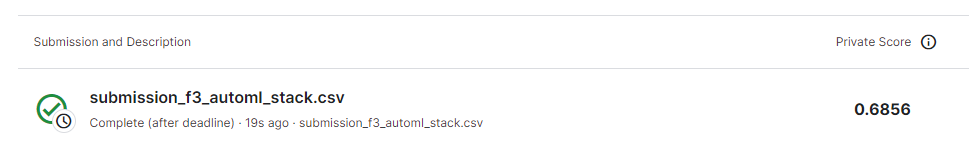

### Итог.  Стекинг не улучшил результат MAE 0.6824 простого lgb.                                                                        MAE 0.6824 это и будет baseline, который я попробую улучшить другими методами в следующем ноутбуке. 